# Import packages

In [2]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

### Set up model

In [45]:
import tensorflow as tf

sigma = 2

def sim_images(cyts, mems, offsets, sigma=sigma, thickness=thickness):
    nimages = cyts.shape[0]
    nfits = cyts.shape[1]
    
    # Positions to evaluate mem and cyt curves
    positions_ = tf.tile(np.arange(thickness, dtype=np.float64), [nimages * nfits])
    offsets_ = tf.reshape(tf.tile(offsets, [1, thickness]), [-1])                 
    positions = tf.math.add(positions_, offsets_)
                           
    # Mem curve
    mem_curve = tf.math.exp(-((positions - thickness / 2) ** 2) / (2 * sigma ** 2))
    mem_curve = tf.reshape(mem_curve, [nimages, nfits, thickness])

    # Cyt curve
    cyt_curve = (1 + tf.math.erf((positions - thickness / 2) / sigma)) / 2
    cyt_curve = tf.reshape(cyt_curve, [nimages, nfits, thickness])

    # Calculate output
    mem_total = mem_curve * tf.expand_dims(mems, axis=-1)
    cyt_total = cyt_curve * tf.expand_dims(cyts, axis=-1)
    return tf.transpose(tf.math.add(mem_total, cyt_total), [0, 2, 1])

def loss_function(target_images, cyts, mems, offsets, sigma=sigma):
    return tf.math.reduce_mean((sim_images(cyts, mems, offsets, sigma=sigma) - target_images) ** 2)

### Initialise parameters

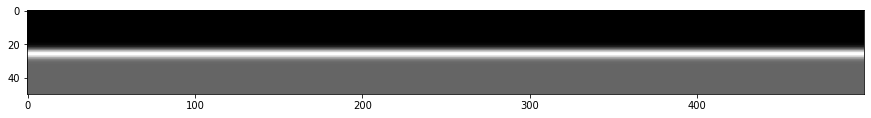

In [40]:
def init_params(target):
    nimages = target.shape[0]
    nfits = target.shape[2]
    
    offsets = tf.Variable(np.zeros([nimages, nfits]))
    cyts = tf.Variable(np.mean(target[:, -5:, :], axis=1))
    mems = tf.Variable(np.max(target, axis=1) - 0.5 * cyts)
    return cyts, mems, offsets
    

thickness = 50
nimages = 5
nfits = 500
offsets_t = tf.Variable(np.zeros([nimages, nfits]))
cyts_t = tf.Variable(1 * np.ones([nimages, nfits]))
mems_t = tf.Variable(2 * np.ones([nimages, nfits]))
target = sim_images(cyts_t, mems_t, offsets_t)

%matplotlib inline
plt.imshow(target[1], cmap='gray')
plt.gcf().set_size_inches(15,15)

### Optimise parameters by gradient descent

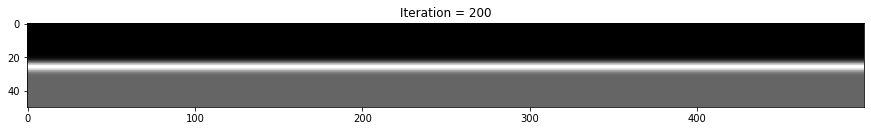

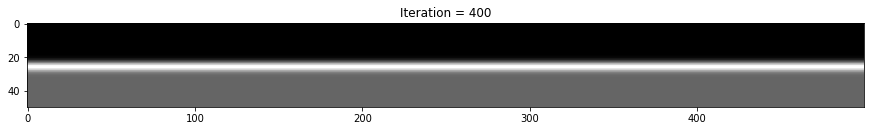

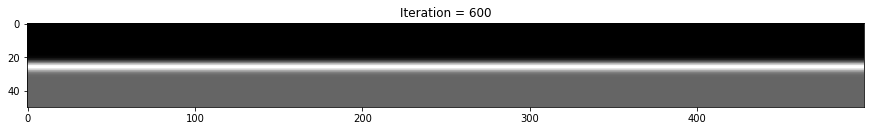

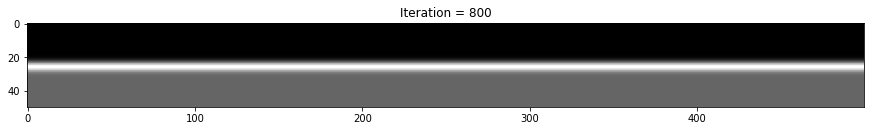

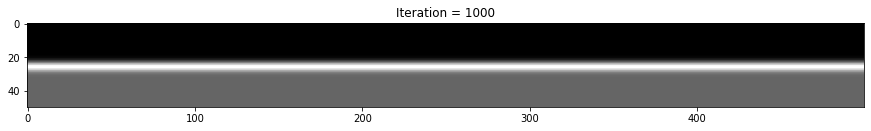

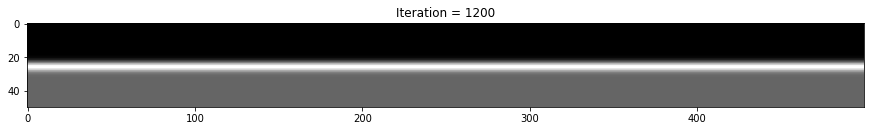

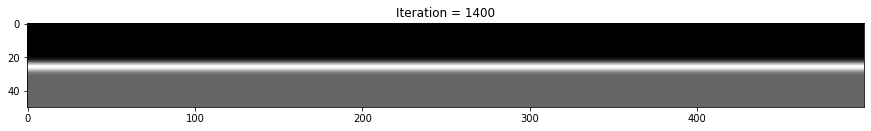

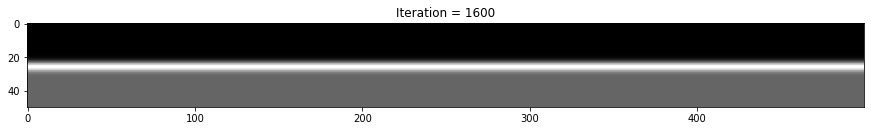

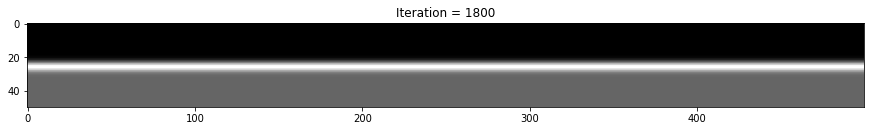

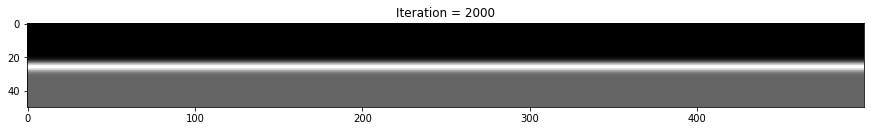

In [41]:
lr = 0.01
iterations = 2000

def optimise(target, lr=lr, iterations=iterations):
    
    # Init parameters
    cyts, mems, offsets = init_params(target)
    
    # Gradient descent
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = np.zeros(iterations)
    for i in range(iterations):   
        with tf.GradientTape() as tape:
            loss = loss_function(target, cyts, mems, offsets)
            losses[i] = loss
            var_list = [offsets, cyts, mems]
            grads = tape.gradient(loss, var_list)
            opt.apply_gradients(list(zip(grads, var_list)))
        
        # Plot fit
        if (i + 1) % 200 == 0: 
            plt.imshow(sim_images(cyts, mems, offsets)[0], cmap='gray')
            plt.title('Iteration = ' + str(i + 1))
            plt.gcf().set_size_inches(15,15)
            plt.show()
            
    return cyts, mems, offsets, losses
            
%matplotlib inline
cyts, mems, offsets, losses = optimise(target)

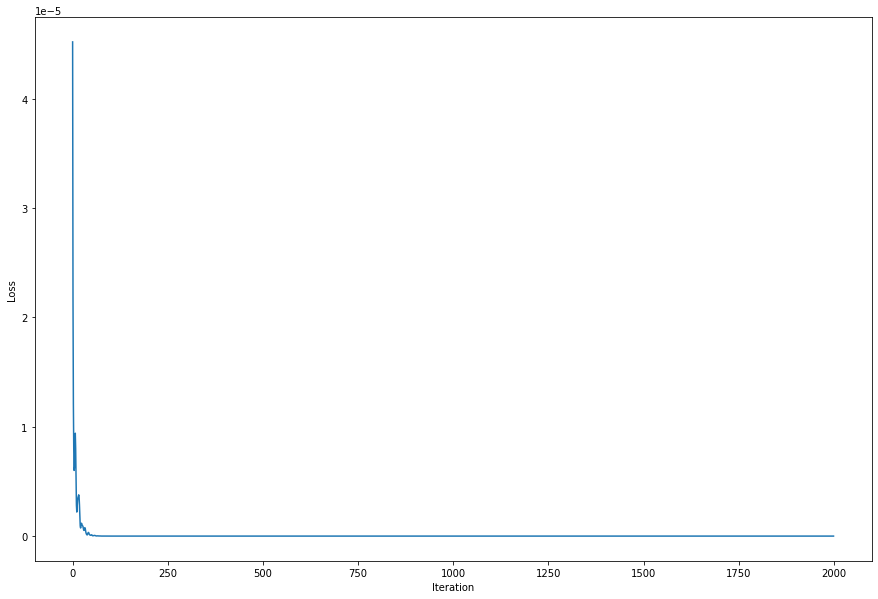

In [42]:
%matplotlib inline
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15,10)

# Global parameter optimisation

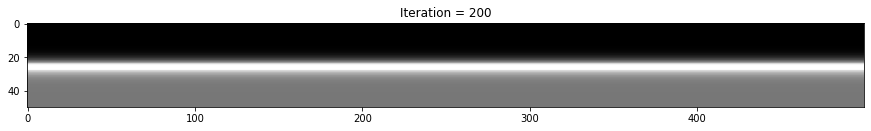

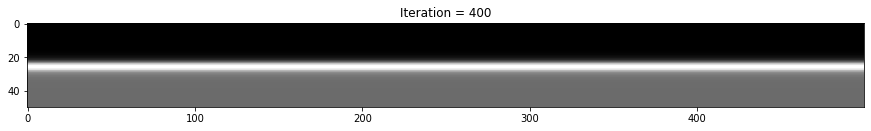

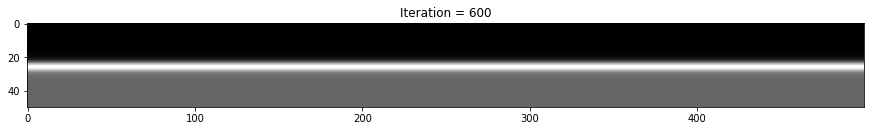

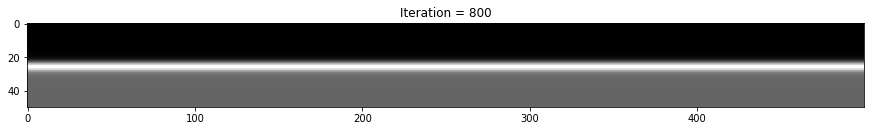

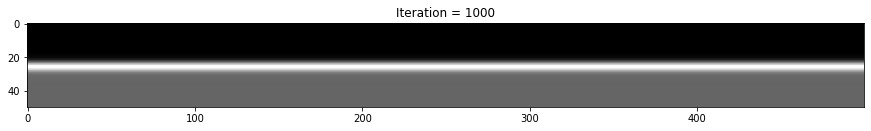

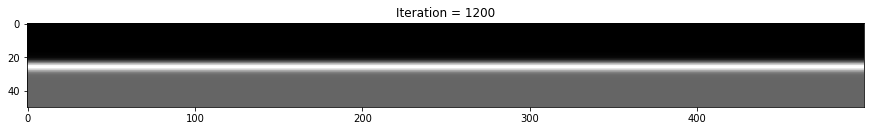

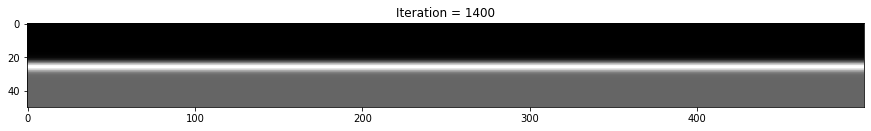

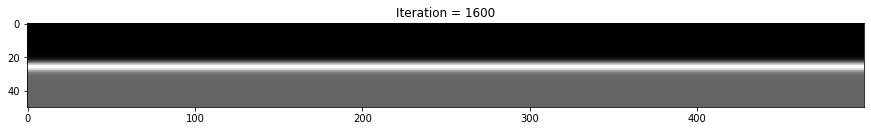

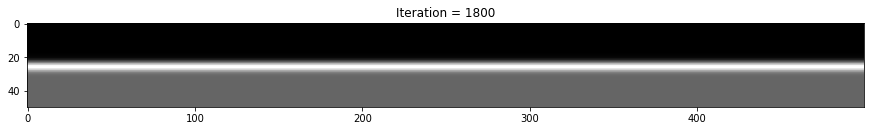

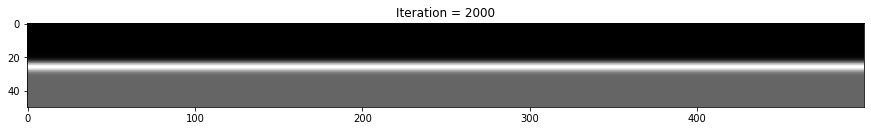

In [50]:
lr = 0.01
iterations = 2000

def optimise(target, lr=lr, iterations=iterations):
    
    # Init parameters
    cyts, mems, offsets = init_params(target)
    sigma = tf.Variable(5, dtype=tf.float64) #####
    
    # Gradient descent
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = np.zeros(iterations)
    for i in range(iterations):   
        with tf.GradientTape() as tape:
            loss = loss_function(target, cyts, mems, offsets, sigma=sigma) 
            losses[i] = loss
            var_list = [offsets, cyts, mems, sigma] #####
            grads = tape.gradient(loss, var_list)
            opt.apply_gradients(list(zip(grads, var_list)))
        
        # Plot fit
        if (i + 1) % 200 == 0: 
            plt.imshow(sim_images(cyts, mems, offsets, sigma=sigma)[0], cmap='gray')
            plt.title('Iteration = ' + str(i + 1))
            plt.gcf().set_size_inches(15,15)
            plt.show()
            
    return cyts, mems, offsets, sigma, losses
            
%matplotlib inline
cyts, mems, offsets, sigma, losses = optimise(target)

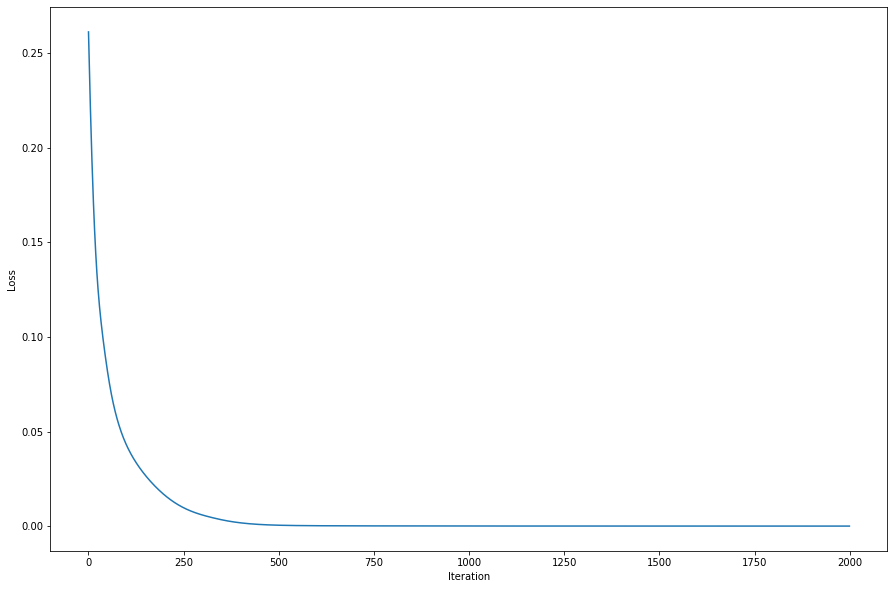

In [51]:
%matplotlib inline
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15,10)